<a href="https://colab.research.google.com/github/stevengregori92/CAPSTONE_GACOR/blob/ml/Terai_Awal_Geb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dataset

In [1]:
!gdown https://drive.google.com/uc?id=1-0QazLXpYyeWO8YtheGN-zvNR-4JSF9c &> /dev/null
!unzip gabungan.zip &> /dev/null
!rm -r gabungan.zip &> /dev/null

# Import Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Preprocessing

In [3]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
    """
    Creates the training and validation data generators

    Args:
        TRAINING_DIR (string): directory path containing the training images
        VALIDATION_DIR (string): directory path containing the testing/validation images

    Returns:
        train_generator, validation_generator - tuple containing the generators
    """
    train_datagen = ImageDataGenerator(rescale=1.0/255,
                                       rotation_range=40,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       shear_range=0.2,
                                       zoom_range=0.2,
                                       horizontal_flip=True,
                                       fill_mode='nearest')

    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=32,
                                                        class_mode='categorical',
                                                        target_size=(224, 224))

    validation_datagen = ImageDataGenerator(rescale=1.0/255)
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                  batch_size=32,
                                                                  class_mode='categorical',
                                                                  target_size=(224, 224))
    return train_generator, validation_generator

# Paths
TRAINING_DIR = '/content/gabungan/train'
VALIDATION_DIR = '/content/gabungan/valid'

train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 16075 images belonging to 8 classes.
Found 2903 images belonging to 8 classes.


# Manual Architecture

In [4]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(8, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

    return model

### Train

In [5]:
model = create_model()
history = model.fit(train_generator,
                    epochs=1,
                    verbose=1,
                    validation_data=validation_generator)

503/503 [==============================] - 219s 423ms/step - loss: 1.7557 - accuracy: 0.3465 - val_loss: 1.5393 - val_accuracy: 0.4292


Text(0.5, 1.0, 'Training and validation loss')

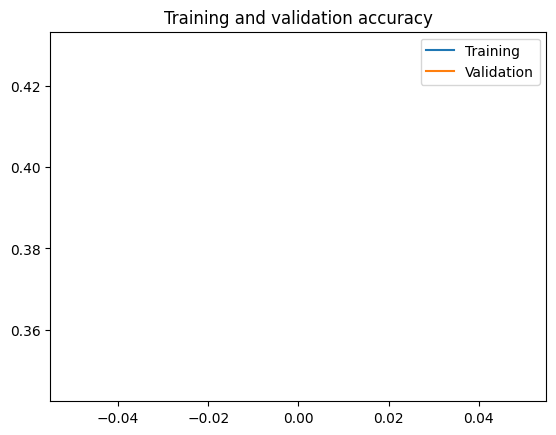

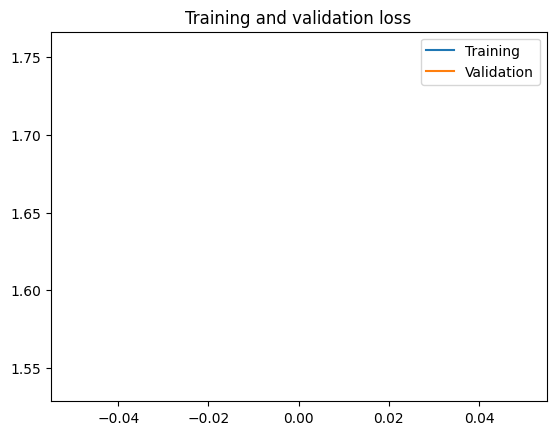

In [6]:
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

plt.plot  ( epochs, acc, label='Training')
plt.plot  ( epochs, val_acc, label='Validation')
plt.title ('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot  ( epochs, loss, label='Training')
plt.plot  ( epochs, val_loss, label='Validation')
plt.legend()
plt.title ('Training and validation loss')

### Saved Model

In [7]:
# Save the model
saved_model_path = "./model.h5"
model.save(saved_model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
# Convert the Keras model to TFLite model
model = tf.keras.models.load_model(saved_model_path)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

177604876

### Convert to TFLITE

In [ ]:
!pip install tflite-support &> /dev/null
!pip uninstall tensorflow &> /dev/null
!pip install tensorflow=="2.13.0" &> /dev/null

In [ ]:
from tflite_support.metadata_writers import writer_utils
from tflite_support.metadata_writers import image_classifier
from tflite_support import metadata

In [ ]:
# Paths for TFLite model and metadata
TFLITE_MODEL_PATH = 'converted_model.tflite'
MODEL_WITH_METADATA_PATH = 'model_with_metadata.tflite'

# Ingat untuk selalu diganti sama label penyakit yang ditrain!
labels = ["Atopic Dermatitis", "Monkeypox", "Psoriasis", "Tinea Ringworm", "Warts Molluscum"]

# Save labels to a temporary file
LABEL_FILE = 'labels.txt'
with open(LABEL_FILE, 'w') as f:
    for label in labels:
        f.write(f"{label}\n")

# Create an ImageClassifierWriter with normalization options
writer = image_classifier.MetadataWriter.create_for_inference(
    model_buffer=writer_utils.load_file(TFLITE_MODEL_PATH),
    input_norm_mean=[127.5],  # Normalization mean
    input_norm_std=[127.5],   # Normalization std
    label_file_paths=[LABEL_FILE]
)

# Populate metadata in the model
model_with_metadata = writer.populate()

# Save the model with metadata
writer_utils.save_file(model_with_metadata, MODEL_WITH_METADATA_PATH)

# Verify the metadata
displayer = metadata.MetadataDisplayer.with_model_file(MODEL_WITH_METADATA_PATH)
print("Metadata populated:")
print(displayer.get_metadata_json())
print("Associated file(s) populated:")
print(displayer.get_packed_associated_file_list())

## RestNet MODEL

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential

In [ ]:
pretrained_model = ResNet50(include_top=False, input_shape=(150, 150, 3), weights='imagenet')
pretrained_model.trainable = False

resnet_model = Sequential()
resnet_model.add(pretrained_model)
resnet_model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
resnet_model.add(MaxPooling2D())
resnet_model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
resnet_model.add(MaxPooling2D())
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dropout(0.5))
resnet_model.add(Dense(3, activation='softmax'))

resnet_model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])

resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 conv2d_4 (Conv2D)           (None, 5, 5, 32)          589856    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 2, 2, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 16)          4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 1, 1, 16)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 16)               

In [ ]:
epochs=2
history = resnet_model.fit(
  train_generator,
  validation_data=validation_generator,
  epochs=epochs
)

Epoch 1/2
217/217 [==============================] - 721s 3s/step - loss: 1.0748 - accuracy: 0.4308 - val_loss: 1.0799 - val_accuracy: 0.4366
Epoch 2/2
217/217 [==============================] - ETA: 0s - loss: 1.0678 - accuracy: 0.4358

In [ ]:
# Save the model
saved_model_path = "./model.h5"
model.save(saved_model_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Convert the Keras model to TFLite model
model = tf.keras.models.load_model(saved_model_path)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

19339648

In [ ]:
# Paths for TFLite model and metadata
TFLITE_MODEL_PATH = 'converted_model.tflite'
MODEL_WITH_METADATA_PATH = 'model_with_metadata.tflite'

# Labels
labels = ["Basal", "Benign", "Melanoma"]

# Save labels to a temporary file
LABEL_FILE = 'labels.txt'
with open(LABEL_FILE, 'w') as f:
    for label in labels:
        f.write(f"{label}\n")

# Create an ImageClassifierWriter with normalization options
writer = image_classifier.MetadataWriter.create_for_inference(
    model_buffer=writer_utils.load_file(TFLITE_MODEL_PATH),
    input_norm_mean=[127.5],  # Normalization mean
    input_norm_std=[127.5],   # Normalization std
    label_file_paths=[LABEL_FILE]
)

# Populate metadata in the model
model_with_metadata = writer.populate()

# Save the model with metadata
writer_utils.save_file(model_with_metadata, MODEL_WITH_METADATA_PATH)

# Verify the metadata
displayer = metadata.MetadataDisplayer.with_model_file(MODEL_WITH_METADATA_PATH)
print("Metadata populated:")
print(displayer.get_metadata_json())
print("Associated file(s) populated:")
print(displayer.get_packed_associated_file_list())

Metadata populated:
{
  "name": "ImageClassifier",
  "description": "Identify the most prominent object in the image from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be classified.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
      "output_tensor_metadata": [
        {
    